In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import PolynomialFeatures
import datetime

In [2]:
data = pd.read_excel('./Приложение №1.xlsx', engine='openpyxl')

In [3]:
atms = data['TERMINAL_ID'].unique()
len(atms)

1146

In [4]:
data['month'] = pd.DatetimeIndex(data['date']).month
data['dayofmonth'] = data['date'].dt.day

### Проведем небольшой EDA

In [5]:
data['sum'].describe().apply("{0:.3f}".format)

count       62936.000
mean      2066957.088
std       2374764.419
min           500.000
25%        493500.000
50%       1342000.000
75%       2783625.000
max      33363000.000
Name: sum, dtype: object

<AxesSubplot:ylabel='Frequency'>

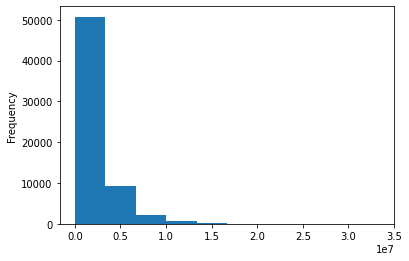

In [6]:
data['sum'].plot.hist()

данные "ровные", никаких аномалий не видно

#### Сделаем пробное предсказание на примере одного из банкоматов

In [7]:
data_by_atm = data[data['TERMINAL_ID'] == 11003]
data_by_atm

,TERMINAL_ID,date,sum,month,dayofmonth
0,11003,2020-07-15,1492000,7,15
1,11003,2020-07-16,2027000,7,16
2,11003,2020-07-17,728000,7,17
3,11003,2020-07-18,890000,7,18
4,11003,2020-07-19,940000,7,19
...,...,...,...,...,...
62,11003,2020-09-15,2752000,9,15
63,11003,2020-09-16,1226000,9,16
64,11003,2020-09-17,1193000,9,17
65,11003,2020-09-18,1512000,9,18


<AxesSubplot:xlabel='date'>

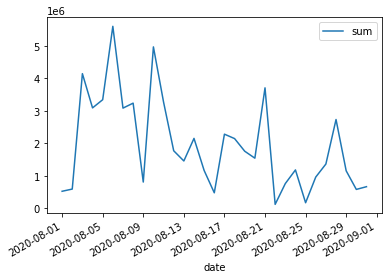

In [8]:
data_by_atm.where(data_by_atm['month'] == 8).plot.line(x='date', y='sum')

In [9]:
x = np.array(data_by_atm['dayofmonth'])
y = np.array(data_by_atm['sum'])

# чтобы не было тупо прямая линия добавим полиноминальные фичи
poly_feat = PolynomialFeatures(degree=2)

x_poly = poly_feat.fit_transform(x.reshape(-1, 1))

x_train, x_test, y_train, y_test = train_test_split(x_poly, y, test_size=0.05, random_state=42)

In [10]:
gb_model = GradientBoostingRegressor(criterion='friedman_mse', learning_rate=0.01, max_depth=6)
gb_model.fit(x_train, y_train)

GradientBoostingRegressor(learning_rate=0.01, max_depth=6)

In [11]:
gb_preds = gb_model.predict(x_test)
gb_preds

array([1891282.78128233, 1160602.65365474, 1554238.66542907,
       1487729.96555776])

In [12]:
gb_score = gb_model.score(x_test, y_test)
gb_score

-0.14797394514747353

In [13]:
y_test

array([1544000, 1152000,  940000, 2031000])

### Предсказание сумм на октябрь

In [14]:
p = [i for i in range(1,32)]
p = np.array(p)
p_poly = poly_feat.fit_transform(p.reshape(-1, 1))

In [15]:
october = gb_model.predict(poly_feat.fit_transform(p.reshape(-1, 1)))
october

array([1506115.02766083, 2235811.80285535, 3201821.99069349,
       3241610.54939917, 2546435.00668397, 2783258.76120427,
       2511089.52075223, 2997857.70663224, 1769845.57369117,
       3766526.71485113, 3045705.48687879, 2012655.18698352,
       1396121.63887174, 1861989.05984976, 1861989.05984976,
       1582787.80743853, 1630593.24494115, 1630593.24494115,
       1554238.66542907, 1891282.78128233, 2415858.61793375,
       1418627.49075654, 1515624.54254173, 1487729.96555776,
       1276301.75137238, 1184059.45702763, 1688063.74571542,
       1878254.04333345, 1707082.77547722, 1699792.14740186,
       1160602.65365474])

In [16]:
data_by_atm_month = data_by_atm[data_by_atm['month'] == 8]   

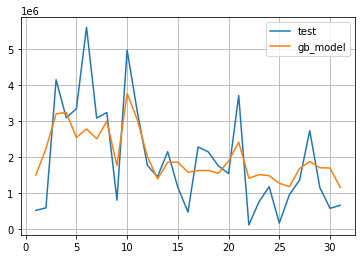

In [17]:
plt.grid()
plt.plot(range(1,len(data_by_atm_month['sum']) + 1), data_by_atm_month['sum'], label = 'test')
plt.plot(range(1, len(october) + 1), october, label = 'gb_model')
plt.legend()
plt.show()

не идеально конечно, но нужно больше данных для того чтобы модель обучилась

### Создание пайплана для остальных банкоматов
так как данные у разных банкоматов могут отличаться, будем обучать модель отедельно по каждому банкомату и давать предикшн по каждому отдельно

In [32]:
def get_predict(atm_id):
    data_by_atm = data[data['TERMINAL_ID'] == atm_id]
    
    # проверка на наличие данных по банкомату. Мало данных смысла нет.
    if len(data_by_atm) > 30:
        
        print(len(data_by_atm))
            
        data_ro_insert = []

        x = np.array(data_by_atm['dayofmonth'])
        y = np.array(data_by_atm['sum'])

        poly_feat = PolynomialFeatures(degree=2)
        x_poly = poly_feat.fit_transform(x.reshape(-1, 1)) 

        x_train, x_test, y_train, y_test = train_test_split(x_poly, y, test_size=0.05, random_state=42)
        gb_model = GradientBoostingRegressor(criterion='friedman_mse', learning_rate=0.01, max_depth=6)
        gb_model.fit(x_train, y_train)

        p = [i for i in range(1,32)]
        p = np.array(p)

        gb_preds = gb_model.predict(poly_feat.fit_transform(p.reshape(-1, 1)))
        new_rows = []

        i = 1
        for r in  gb_preds:
            row = {}
            date = str(f"{i}.10.2020")
            row = {'TERMINAL_ID': atm_id, 'date': date, 'sum': round(r)}
            i += 1
            new_rows.append(row)


        output_data = pd.DataFrame(new_rows)

        return output_data

    

In [30]:
for atm in atms:
    data_by_atm = data[data['TERMINAL_ID'] == atm]
    
    if len(data_by_atm) == 0:
        print('Нет данных по банкомату!')
    else:
        print(f"atm - {len(data_by_atm)}")
    

atm - 67
atm - 67
atm - 64
atm - 65
atm - 64
atm - 3
atm - 67
atm - 64
atm - 63
atm - 66
atm - 65
atm - 28
atm - 66
atm - 64
atm - 67
atm - 25
atm - 67
atm - 64
atm - 62
atm - 59
atm - 67
atm - 65
atm - 59
atm - 15
atm - 65
atm - 21
atm - 67
atm - 67
atm - 67
atm - 67
atm - 25
atm - 66
atm - 64
atm - 67
atm - 65
atm - 61
atm - 45
atm - 67
atm - 36
atm - 59
atm - 55
atm - 39
atm - 65
atm - 38
atm - 66
atm - 65
atm - 46
atm - 58
atm - 67
atm - 67
atm - 65
atm - 67
atm - 55
atm - 53
atm - 65
atm - 67
atm - 62
atm - 61
atm - 48
atm - 49
atm - 34
atm - 55
atm - 36
atm - 67
atm - 43
atm - 60
atm - 53
atm - 42
atm - 40
atm - 50
atm - 64
atm - 67
atm - 67
atm - 34
atm - 29
atm - 40
atm - 63
atm - 44
atm - 42
atm - 64
atm - 66
atm - 66
atm - 52
atm - 29
atm - 11
atm - 65
atm - 65
atm - 41
atm - 67
atm - 66
atm - 2
atm - 67
atm - 65
atm - 67
atm - 63
atm - 60
atm - 66
atm - 58
atm - 57
atm - 61
atm - 61
atm - 66
atm - 55
atm - 62
atm - 35
atm - 63
atm - 67
atm - 65
atm - 23
atm - 10
atm - 50
atm

In [33]:
predict_data = pd.DataFrame(columns=('TERMINAL_ID', 'date', 'sum'))

for atm in atms:
    output_data = get_predict(atm)
    #if output_data != 'Нет данных по банкомату!':
    predict_data = predict_data.append(output_data)
    #else:
    #    print('Нет данных по банкому!')

67
67
64
65
64
67
64
63
66
65
66
64
67
67
64
62
59
67
65
59
65
67
67
67
67
66
64
67
65
61
45
67
36
59
55
39
65
38
66
65
46
58
67
67
65
67
55
53
65
67
62
61
48
49
34
55
36
67
43
60
53
42
40
50
64
67
67
34
40
63
44
42
64
66
66
52
65
65
41
67
66
67
65
67
63
60
66
58
57
61
61
66
55
62
35
63
67
65
50
67
57
65
52
55
54
46
65
55
62
53
64
53
55
35
65
64
52
67
49
63
67
54
66
50
67
49
60
67
63
49
56
67
61
61
56
55
67
39
67
47
52
67
57
31
52
61
51
57
66
47
46
66
51
67
47
65
49
66
67
67
62
60
51
63
63
36
67
50
64
66
36
67
55
67
51
44
67
53
58
53
65
58
60
48
67
59
44
55
58
58
35
67
67
65
52
67
67
67
54
57
64
65
39
54
44
66
48
50
55
66
37
54
66
40
58
61
64
66
55
39
51
64
55
67
64
62
67
67
50
63
49
58
51
66
66
67
67
52
54
48
67
67
60
66
67
66
64
67
58
65
67
67
66
65
57
62
64
67
65
67
67
64
65
46
67
66
50
67
65
35
66
67
53
67
66
67
31
63
66
61
52
66
67
53
67
67
67
67
67
66
67
67
57
65
40
50
45
49
37
31
45
40
32
66
53
56
66
58
41
31
66
46
55
44
65
43
64
50
66
39
55
54
67
45
67
45
67
65
53
67
63
53
65
6

In [34]:
predict_data

,TERMINAL_ID,date,sum
0,11003,1.10.2020,1506115
1,11003,2.10.2020,2235812
2,11003,3.10.2020,3201822
3,11003,4.10.2020,3241611
4,11003,5.10.2020,2546435
...,...,...,...
26,82012,27.10.2020,587894
27,82012,28.10.2020,587894
28,82012,29.10.2020,5555634
29,82012,30.10.2020,3111372


In [38]:
predict_data.to_excel('atms_predict.xlsx')